# Explicabilidad de las recomendaciones

En este *notebook* vamos a intentar explicar los resultados que se obtienen como recomendaciones a partir de un usuario. Para ello, se intentará encontrar una relación entre el embedding de usuario y los embeddings de libros que el sistema recomienda.

In [1]:
import os
import pandas as pd

# Ruta de datasets procesados
ready_path = os.path.join(os.getcwd(), "../..", "datasets", "ready")

# Lectura del dataset de ratings procesado
col_types = {
    'user_id': 'int32',
    'book_id': 'int32',
    'rating': 'float32',
}

ratings_df = pd.read_csv(ready_path + "/ratings.csv", dtype=col_types)
print("# de ratings:", ratings_df.shape[0])

# de ratings: 5515602


In [2]:
# Ruta de datasets en bruto
raw_path = os.path.join(os.getcwd(), "../..", "datasets", "raw")

# Lectura del dataset de libros
books_df = pd.DataFrame(pd.read_pickle(raw_path + "/books_raw.pkl"))
print("# de libros:", books_df.shape[0])

# de libros: 9467


In [3]:
# IDs de usuarios
user_ids = ratings_df['user_id'].unique()
print("# de usuarios:", len(user_ids))

# de usuarios: 52371


In [4]:
import random

# Selección de num_users usuarios aleatorios
random.seed(42)
num_users = 10000
user_ids_reduced = random.sample(list(user_ids), num_users)
print("# de usuarios:", len(user_ids_reduced))
ratings_reduced_df = ratings_df[ratings_df['user_id'].isin(user_ids_reduced)]
print("# de ratings:", ratings_reduced_df.shape[0])

# de usuarios: 10000
# de ratings: 1053374


In [5]:
# Creamos los datasets de train (80%) y test (20%)
import sklearn.model_selection as model_selection

train, test = model_selection.train_test_split(ratings_reduced_df, test_size=0.2, random_state=42)
books_test = test['book_id'].unique()
train = train[train['book_id'].isin(books_test)]
# Creamos el dataframe de entrenamiento para el modelo a partir del dataset de train
train_df = pd.DataFrame(train, columns=['user_id', 'book_id', 'rating'])
train_df.sort_values(by=['user_id', 'book_id'], inplace=True)
train_df.reset_index(drop=True, inplace=True)
train_df.head()

,user_id,book_id,rating
0,8,13,0.75
1,8,14,1.00
2,8,28,0.75
3,8,43,0.25
4,8,45,0.50


In [6]:
import numpy as np

def create_user_feature(user_id: int, feature: str, train_df: pd.DataFrame, books_df: pd.DataFrame):
    """
    Crea un vector normalizado de la característica dada a partir
    de los libros que al usuario le gustaron (rating >= 0.75). El vector
    es la suma ponderada de los vectores de la característica dada de
    dichos libros, donde los pesos son los ratings de los libros.

    ## Parámetros
    - user_id: ID del usuario.
    - feature: Nombre de la característica (columna) a calcular.
    - train_df: `DataFrame` del dataset de entrenamiento.
    - books_df: `DataFrame` de libros en el dataset de entrenamiento.

    ## Retorna
    Vector normalizado de la característica dada.
    """
    # Ratings positivas del usuario
    user_ratings = train_df[train_df['user_id'] == user_id]
    user_likes = user_ratings[user_ratings['rating'] >= 0.75]
    # Libros que le gustaron al usuario
    user_books = books_df[books_df['book_id'].isin(user_likes['book_id'])]
    feature_array = np.array(user_books[feature])
    # Media ponderada de los vectores de la característica dada de los libros
    user_feature = np.sum([feature_array[i]*np.array(user_likes['rating'])[i] for i in range(len(feature_array))], axis=0)
    total_ratings_sum = np.sum(np.array(user_likes['rating']))
    if total_ratings_sum != 0:
        user_feature = user_feature/total_ratings_sum
    # Se retorna el vector normalizado
    norm = np.linalg.norm(user_feature)
    if norm == 0:
        return user_feature
    return user_feature/norm

In [7]:
# Ruta de almacenamiento de modelos
models_path = os.path.join(os.getcwd(), "../..", "models")

# Usuarios del modelo entrenado, referencia para recomendaciones
model_df = pd.DataFrame(pd.read_pickle(models_path + "/user_profiles.pkl"))

In [8]:
# Definimos la función de similitud entre dos objetos
def sem_sent_sim(item1, item2, sem_option='semantic_sbert', sem_w=1.0) -> float:
    """
    Calcula la similitud entre un objeto y otro.
    Los objetos deben tener un vector `'semantic'` y otro `'sentiment'`, 
    previamente normalizados.

    La similitud sigue la siguiente fórmula:

    sim(item1, item2) = sem_w * cos_sim(item1[sem_option], item2[sem_option]) + 
    (1 - sem_w) * cos_sim(item1['sentiment'], item2['sentiment'])

    ## Parámetros:
    - item1: Primer objeto.
    - item2: Segundo objeto.
    - sem_option: Opción de contenido semántico. Por defecto su valor
    es `'semantic_sbert'` (modelo SBERT), pero también puede valer `'semantic_use'`
    (modelo USE).
    - sem_w: Peso del contenido semántico. Por defecto su valor es 1.

    ## Retorna:
    La similitud entre ambos objetos.
    """
    # Obtenemos el campo semántico de cada objeto
    sem1 = item1[sem_option]
    sem2 = item2[sem_option]
    # Obtenemos el campo de sentimiento de cada objeto
    sent1 = item1['sentiment']
    sent2 = item2['sentiment']
    # Calculamos la similitud
    return sem_w * np.dot(sem1, sem2) + (1 - sem_w) * np.dot(sent1, sent2)

def sem_sent_dist(item1, item2, sem_option='semantic_sbert', sem_w=1.0) -> float:
    """
    Calcula la distancia entre un objeto y otro.

    Los objetos deben tener un vector 'semantic' y otro 'sentiment', 
    previamente normalizados.

    La similitud sigue la siguiente fórmula:

    dist(item1, item2) = 1 - sim(item1, item2)

    ## Parámetros:
    - item1: Primer objeto.
    - item2: Segundo objeto.
    - sem_option: Opción de contenido semántico. Por defecto su valor
    es `'semantic_sbert'` (modelo SBERT), pero también puede valer `'semantic_use'`
    (modelo USE).
    - sem_w: Peso del contenido semántico. Por defecto su valor es 1.0.

    ## Retorna:
    La distancia entre ambos objetos.
    """
    return 1 - sem_sent_sim(item1, item2, sem_option, sem_w)

In [9]:
from typing import List, Tuple, Dict

def k_nearest(
    user_id, users_df: pd.DataFrame, k=35, sem_option='semantic_sbert', sem_w=1.0
) -> List[Tuple[int, float]]:
    """
    Calcula los k usuarios más cercanos a un usuario.

    ## Parámetros:
    - user_id: ID del usuario del que queremos obtener los k usuarios más cercanos.
    - users_df: `DataFrame` de perfiles de usuarios en el dataset de entrenamiento.
    - k: Número de vecinos más cercanos que queremos obtener.
    - sem_option: Opción de contenido semántico. Por defecto su valor
    es `'semantic_sbert'` (modelo SBERT), pero también puede valer `'semantic_use'`
    (modelo USE).
    - sem_w: Peso del contenido semántico. Por defecto su valor es 1.

    ## Retorna:
    k tuplas (user_id, similitud) con los k usuarios más cercanos al usuario.
    """
    # Obtenemos el usuario
    user = users_df[users_df['user_id'] == user_id].iloc[0]
    # Quitamos el usuario del dataset de usuarios
    users_df = users_df[users_df['user_id'] != user_id]
    # Calculamos las distancias entre el usuario y todos los demás
    sim_users = users_df.apply(lambda x: (x['user_id'], sem_sent_sim(user, x, sem_option, sem_w)), axis=1)
    # Obtenemos los k vecinos más cercanos
    nearest = list(sim_users)
    nearest.sort(key=lambda x: x[1], reverse=True)
    return nearest[:k]

In [10]:
def top_k_books(
    user_id: int, sim_users: List[Tuple[int, float]], train_df: pd.DataFrame, k: int=5
) -> List[Tuple[int, float]]:
    """
    Obtiene los libros mejor valorados por los k usuarios más cercanos al usuario.

    ## Parámetros:
    - user_id: ID del usuario del que queremos obtener los k usuarios más cercanos.
    - sim_users: Lista de tuplas (user_id, similitud) con los k usuarios más cercanos al usuario.
    - train_df: `DataFrame` del dataset de entrenamiento.
    - k: Número de libros que queremos obtener. Por defecto su valor es 5.

    ## Retorna:
    Lista de tuplas (book_id, prediction) con los k libros que se recomiendan al usuario.
    """
    # Obtenemos los k usuarios más cercanos
    nearest_users = [user[0] for user in sim_users]
    # Obtenemos los ratings de los k usuarios más cercanos
    nearest_ratings = train_df[train_df['user_id'].isin(nearest_users)]
    # Obtenemos los libros mejor valorados por los k usuarios más cercanos
    nearest_likes = nearest_ratings[nearest_ratings['rating'] >= 0.75]
    # Obtenemos los libros que no ha valorado el usuario
    user_ratings = train_df[train_df['user_id'] == user_id]
    user_books = user_ratings['book_id'].unique()
    nearest_likes = nearest_likes[~nearest_likes['book_id'].isin(user_books)]
    # Multiplicamos los ratings por la similitud
    nearest_likes['rating'] = nearest_likes.apply(
        lambda x: x['rating'] * sim_users[nearest_users.index(x['user_id'])][1], axis=1
    )
    # Agrupamos por libro sumando el campo rating
    nearest_likes = nearest_likes.groupby(['book_id']).sum()
    # Ordenamos por rating
    nearest_likes.sort_values(by=['rating'], ascending=False, inplace=True)
    # Obtenemos los k libros con mayor rating
    return list(zip(nearest_likes.index[:k], nearest_likes['rating'][:k]))

In [11]:
def recommend_books(
    user_id: int, users_df: pd.DataFrame, train_df: pd.DataFrame, k: int=5
) -> List[Tuple[int, float]]:
    """
    Recomienda libros a un usuario.

    ## Parámetros:
    - user_id: ID del usuario al que queremos recomendar libros.
    - users_df: `DataFrame` de perfiles de usuarios del modelo entrenado.
    - train_df: `DataFrame` del dataset de entrenamiento.
    - k: Número de libros que queremos obtener. Por defecto su valor es 5.

    ## Retorna:
    Lista de tuplas (book_id, prediction) con los k libros que se recomiendan al usuario.
    """
    # Obtenemos los k usuarios más cercanos
    sim_users = k_nearest(user_id, users_df)
    # Obtenemos los libros mejor valorados por los k usuarios más cercanos
    return top_k_books(user_id, sim_users, train_df, k)

In [12]:
from ast import literal_eval

# Dataset de libros con la información original
path = '../../datasets/goodbooks_ext/'
books_full_df = pd.read_csv(path + 'books_enriched.csv', index_col=[0], converters={"genres": literal_eval})

In [13]:
def get_book_titles(book_ids: List[int], books_full_df: pd.DataFrame) -> List[str]:
    """
    Obtiene los títulos de los libros.

    ## Parámetros:
    - book_ids: Lista de IDs de libros.
    - books_full_df: `DataFrame` de libros con la información original.

    ## Retorna:
    Lista de títulos de los libros.
    """
    return [
        str(books_full_df[books_full_df['book_id'] == book_id]['title'].values[0]) 
        for book_id in book_ids
    ]

def get_book_summaries(book_ids: List[int], books_full_df: pd.DataFrame) -> List[str]:
    """
    Obtiene los resúmenes de los libros.

    ## Parámetros:
    - book_ids: Lista de IDs de libros.
    - books_full_df: `DataFrame` de libros con la información original.

    ## Retorna:
    Lista de resúmenes de los libros.
    """
    return [
        str(books_full_df[books_full_df['book_id'] == book_id]['description'].values[0]) 
        for book_id in book_ids
    ]

Por un lado, podemos mostrar la puntuación que obtiene cada libro en orden de recomendación, métrica del sistema de recomendación.

In [14]:
def print_recommended_book_titles_score(
    recommended_books: List[Tuple[int, str]], books_full_df: pd.DataFrame
) -> None:
    """
    Imprime los títulos de los libros recomendados, junto a su puntuación.

    ## Parámetros:
    - recommended_books: Lista de tuplas (ID, puntuación) de libros recomendados.
    - books_full_df: `DataFrame` de libros con la información original.
    """
    book_ids = [book[0] for book in recommended_books]
    titles = get_book_titles(book_ids, books_full_df)
    for (i, title), (_, score) in zip(enumerate(titles), recommended_books):
        print(f"{i + 1}. {title} -> {score:.2f}")

In [15]:
recommended_books = recommend_books(8, model_df, train_df, 5)
print_recommended_book_titles_score(recommended_books, books_full_df)

1. The Catcher in the Rye -> 15.24
2. Of Mice and Men -> 12.14
3. The Picture of Dorian Gray -> 11.90
4. The Old Man and the Sea -> 11.89
5. One Flew Over the Cuckoo's Nest -> 11.88


Por otro lado, también se puede mostrar la similitud de los libros con el perfil de usuario como tal (modelo base, que descartamos en favor del modelo híbrido).

In [16]:
def get_book_vector(book_id: int, books_df: pd.DataFrame) -> np.ndarray:
    """
    Obtiene el vector del libro.

    ## Parámetros:
    - book_id: ID del libro.
    - books_df: `DataFrame` de libros en el dataset de entrenamiento.

    ## Retorna:
    Vector del libro.
    """
    return np.array(
        books_df[books_df['book_id'] == book_id].iloc[0]['semantic_sbert']
    )


def get_book_vectors(book_ids: List[int], books_df: pd.DataFrame) -> np.ndarray:
    """
    Obtiene los vectores de los libros.

    ## Parámetros:
    - book_ids: Lista de IDs de libros.
    - books_df: `DataFrame` de libros en el dataset de entrenamiento.

    ## Retorna:
    Matriz con los vectores de los libros.
    """
    return np.array(
        books_df[
            books_df['book_id'].isin(
                book_ids)
        ]['semantic_sbert'].to_list()
    )


def get_user_vector(user_id: int, model_df: pd.DataFrame) -> np.ndarray:
    """
    Obtiene el vector del usuario.

    ## Parámetros:
    - user_id: ID del usuario.
    - model_df: `DataFrame` de perfiles de usuarios en el modelo entrenado.

    ## Retorna:
    Vector del usuario.
    """
    return np.array(
        model_df[model_df['user_id'] == user_id].iloc[0]['semantic_sbert']
    )


def get_user_vectors(user_ids: List[int], model_df: pd.DataFrame) -> np.ndarray:
    """
    Obtiene los vectores de los usuarios.

    ## Parámetros:
    - user_ids: IDs de usuarios.
    - model_df: `DataFrame` de perfiles de usuarios en el modelo entrenado.

    ## Retorna:
    Vector del usuario.
    """
    return np.array(
        model_df[model_df['user_id'].isin(
            user_ids)]['semantic_sbert'].to_list()
    )

In [62]:
def get_liked_books(user_id: int, train_df: pd.DataFrame) -> List[int]:
    """
    Obtiene los libros que le gustan al usuario.

    ## Parámetros:
    - user_id: ID del usuario.
    - train_df: `DataFrame` del dataset de entrenamiento.

    ## Retorna:
    Lista de IDs de libros que le gustan al usuario.
    """
    return list(
        train_df[
            (train_df['user_id'] == user_id) & (train_df['rating'] >= 0.75)
        ]['book_id']
    )

In [17]:
def print_recommended_book_titles_sim(
    book_ids: List[int],
    books_df: pd.DataFrame,
    books_full_df: pd.DataFrame,
    user_id: int,
    model_df: pd.DataFrame
) -> None:
    """
    Imprime los títulos de los libros recomendados, junto a su similitud.

    ## Parámetros:
    - book_ids: Lista de IDs de libros recomendados.
    - books_df: `DataFrame` de libros en el dataset de entrenamiento.
    - books_full_df: `DataFrame` de libros con la información original.
    - user_id: ID del usuario.
    - model_df: `DataFrame` de perfiles de usuarios en el modelo entrenado.
    """
    titles = get_book_titles(book_ids, books_full_df)
    book_vectors = get_book_vectors(book_ids, books_df)
    user_vector = get_user_vector(user_id, model_df)
    similarities = np.dot(book_vectors, user_vector)
    for (i, title), sim in zip(enumerate(titles), similarities):
        print(f"{i + 1}. {title} -> {100*sim:.1f}%")

In [18]:
book_ids = [book[0] for book in recommended_books]
print_recommended_book_titles_sim(book_ids, books_df, books_full_df, 8, model_df)

1. The Catcher in the Rye -> 62.3%
2. Of Mice and Men -> 61.4%
3. The Picture of Dorian Gray -> 63.7%
4. The Old Man and the Sea -> 37.5%
5. One Flew Over the Cuckoo's Nest -> 54.7%


Se puede también presentar ambas métricas diciendo que, en base al recomendador, los libros que se recomiendan teniendo en cuenta sus descripciones y los usuarios que tienen un perfil más próximo al usuario y, además, mostrar las métricas de similitud frente a los libros para dar una idea de cómo de parecido es un único libro respecto del perfil de usuario.

In [32]:
def print_recommended_book_titles_score_sim(
    recommended_books: List[Tuple[int, float]],
    books_df: pd.DataFrame,
    books_full_df: pd.DataFrame,
    user_id: int,
    model_df: pd.DataFrame
) -> None:
    """
    Imprime los títulos de los libros recomendados, junto a su puntuación y similitud.
    
    ## Parámetros:
    - recommended_books: Lista de tuplas (ID, puntuación) de libros recomendados.
    - books_df: `DataFrame` de libros en el dataset de entrenamiento.
    - books_full_df: `DataFrame` de libros con la información original.
    - user_id: ID del usuario.
    - model_df: `DataFrame` de perfiles de usuarios en el modelo entrenado.
    """
    book_ids = [book[0] for book in recommended_books]
    scores = [book[1] for book in recommended_books]
    titles = get_book_titles(book_ids, books_full_df)
    book_vectors = get_book_vectors(book_ids, books_df)
    user_vector = get_user_vector(user_id, model_df)
    similarities = np.dot(book_vectors, user_vector)
    for (i, title), score, sim in zip(enumerate(titles), scores, similarities):
        print(f"{i + 1}. {title} -> {score:.2f} - {100*sim:.1f}%")

In [33]:
recommended_books = recommend_books(8, model_df, train_df, 5)
print_recommended_book_titles_score_sim(recommended_books, books_df, books_full_df, 8, model_df)

1. The Catcher in the Rye -> 15.24 - 62.3%
2. Of Mice and Men -> 12.14 - 61.4%
3. The Picture of Dorian Gray -> 11.90 - 63.7%
4. The Old Man and the Sea -> 11.89 - 37.5%
5. One Flew Over the Cuckoo's Nest -> 11.88 - 54.7%


En el caso anterior, se recomiendan los libros con IDs 8, 32, 95, 130 y 129 en base a los libros más comunes entre los usuarios con un perfil más semejante al del usuario al que se le está recomendando libros. Sin embargo, vemos que los dos últimos libros no guardan mucho parecido ya respecto de su perfil en comparación con los otros tres que se recomiendan. Por tanto, indicando un porcentaje de coincidencia de cada libro recomendado con su perfil aporta más información a la recomendación.

Otra idea que hemos pensado es comprobar, dimensión a dimensión, si la coordenada del vector de usuario es mayor o menor que la del libro recomendado. Con esto se puede construir un vector de 1's y -1's, que indica qué aspectos pesan en el libro sobre el usuario. El problema de este método es intentar interpretar el significado de cada dimensión del vector. Los embeddings de SBERT suponen un desafío a la hora de explicar la predicción de cada coordenada al construir la similitud semántica entre oraciones del lenguaje. Algo que, probablemente, queda fuera del alcance del proyecto.

In [ ]:
def get_xai_vector(user_vector: np.ndarray, book_vector: np.ndarray) -> np.ndarray:
    """
    Obtiene el vector de explicabilidad de un libro para un usuario.

    ## Parámetros:
    - user_vector: Vector del usuario.
    - book_vector: Vector del libro.

    ## Retorna:
    Vector de explicabilidad del libro para el usuario.
    """
    xai_vector = np.array(book_vector)
    for i in range(len(book_vector)):
        if user_vector[i] > book_vector[i]:
            xai_vector[i] = -1
        else:
            xai_vector[i] = 1
            
    return xai_vector

user_vector = get_user_vector(8, model_df)
book_vectors = get_book_vectors([book[0] for book in recommended_books], books_df)
get_xai_vector(user_vector, book_vectors[0])

También podemos practicar una reducción de dimensionalidad para intentar visualizar en el plano o el espacio euclídeo el vector del usuario frente a los vectores de los libros que se recomiendan. Utilizar t-SNE o UMAP.

In [ ]:
import umap
import sklearn.datasets
import umap.plot
import matplotlib.pyplot as plt

In [ ]:
book_ids = train_df['book_id'].unique()
book_mapper = umap.UMAP().fit(get_book_vectors(book_ids, books_df))

/usr/local/lib/python3.10/dist-packages/umap/plot.py:449: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], s=point_size, c=color)


<Axes: >

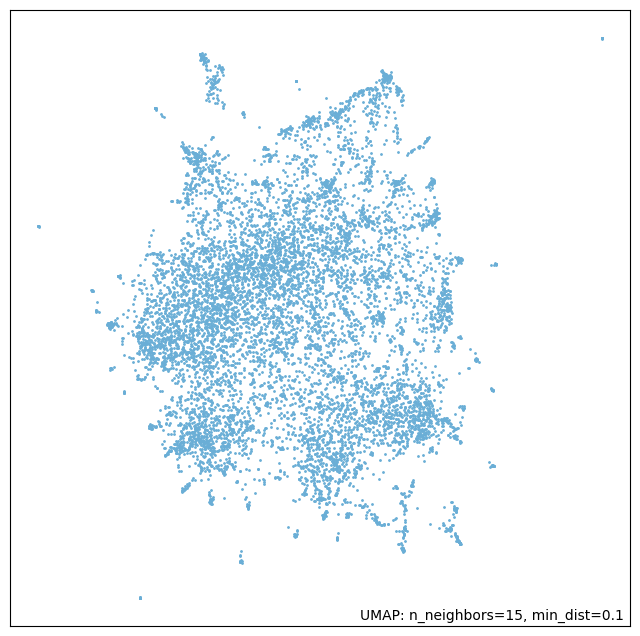

In [ ]:
umap.plot.points(book_mapper)

/usr/local/lib/python3.10/dist-packages/umap/plot.py:894: UserWarning: Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!
  warn(


<Axes: >

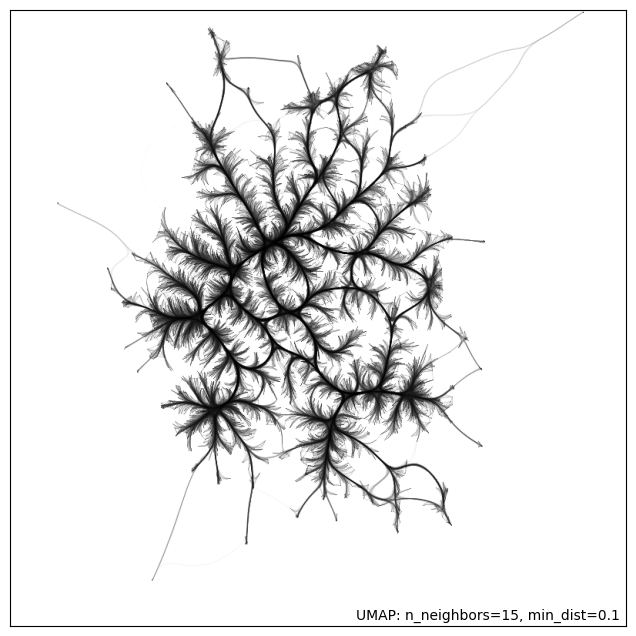

In [ ]:
umap.plot.connectivity(book_mapper, edge_bundling="hammer")

<Axes: title={'center': 'Colored by RGB coords of PCA embedding'}>

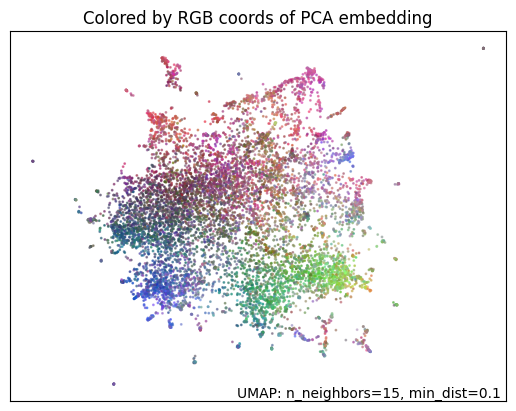

In [ ]:
umap.plot.diagnostic(book_mapper, diagnostic_type="pca")

In [ ]:
user_ids = model_df['user_id'].unique()
user_mapper = umap.UMAP().fit(get_user_vectors(user_ids, model_df))

/usr/local/lib/python3.10/dist-packages/umap/plot.py:449: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], s=point_size, c=color)


<Axes: >

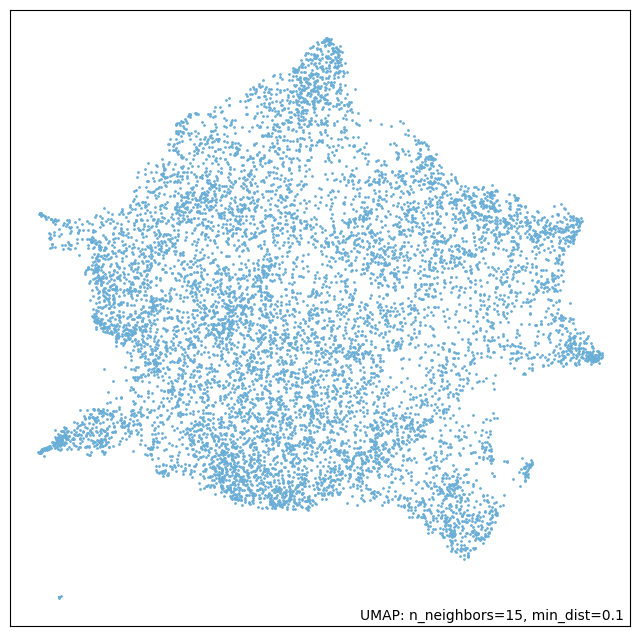

In [ ]:
umap.plot.points(user_mapper)

/usr/local/lib/python3.10/dist-packages/umap/plot.py:894: UserWarning: Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!
  warn(


<Axes: >

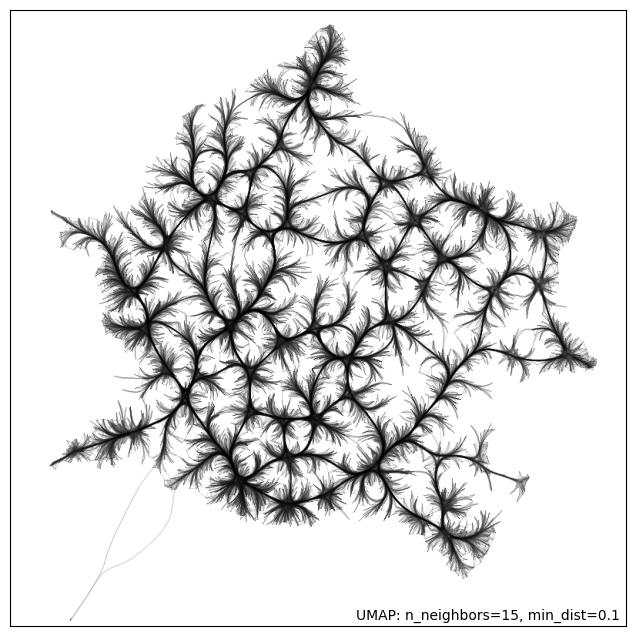

In [ ]:
umap.plot.connectivity(user_mapper, edge_bundling="hammer")

<Axes: title={'center': 'Colored by RGB coords of PCA embedding'}>

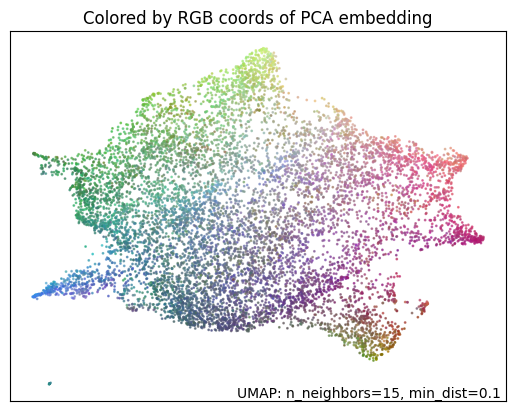

In [ ]:
umap.plot.diagnostic(user_mapper, diagnostic_type="pca")

Otra idea interesante es la de encontrar las palabras clave de las descripciones de los libros que han sido recomendados. Podemos extraer estas palabras con diversas técnicas de NLP, pero para continuar con la filosofía de BERT, emplearemos la librería `keybert`, que podemos encontrar en [este](https://github.com/MaartenGr/KeyBERT) repositorio. 

El objetivo es mostrar las palabras clave junto a una frecuencia de entre todos los libros recomendados, para determinar si existe cierta relación que pueda satisfacer al usuario a la hora de intentar comprender el porqué de esas recomendaciones. Como la técnica por detrás de este método es también la utilización de embeddings construidos sobre el contexto y la similitud semántica, la conexión entre recomendación y explicación es más fuerte (se tienen en cuenta modelos y estrategias NLP idénticas tanto para recomendar como para extraer información de ayuda para construir una posible explicación).

In [20]:
def keyword_freqs(keywords: List[List[Tuple[str, float]]]) -> Dict[str, int]:
    """
    Obtiene la frecuencia de las palabras clave.
    
    ## Parámetros:
    - keywords: Lista de listas de tuplas (palabra, similitud con texto).
    
    ## Retorna:
    Diccionario con la frecuencia de las palabras clave.
    """
    word_freq = {}
    for doc in keywords:
        for word, _ in doc:
            if word in word_freq:
                word_freq[word] += 1
            else:
                word_freq[word] = 1

    word_freq = {
        k: v for k, v in sorted(
            word_freq.items(), key=lambda item: item[1], reverse=True
        )
    }
    
    return word_freq

In [21]:
from keybert import KeyBERT

# Inicializa el modelo (ponemos el que usamos para generar embeddings)
kw_model = KeyBERT(model="all-distilroberta-v1")

# Obtiene las descripciones de los libros recomendados
book_summaries = get_book_summaries(book_ids, books_full_df)

# Obtiene las palabras clave de las descripciones
keywords = kw_model.extract_keywords(book_summaries)

In [41]:
keyword_freqs(keywords)

{'novel': 5,
 'catcher': 1,
 'novels': 1,
 'reader': 1,
 'narrator': 1,
 'mice': 1,
 'steinbeck': 1,
 'films': 1,
 'men': 1,
 'wilde': 1,
 'autobiography': 1,
 'moral': 1,
 'hallward': 1,
 'marlin': 1,
 'fisherman': 1,
 'author': 1,
 'literature': 1,
 'nurse': 1,
 'tyrannical': 1,
 'patient': 1,
 'ratched': 1}

Otra técnica es encontrar las palabras más importantes con la ya comentada librería spaCy mediante la tokenización del texto. Esto es, separando en términos el texto y teniendo en cuenta nombres propios, sustantivos y adjetivos. Aplicando un contador a las palabras más importantes, mostramos las palabras más comunes de entre los libros recomendados.

In [23]:
import spacy
from collections import Counter
from string import punctuation


nlp = spacy.load("en_core_web_lg")


def get_hotwords(text: str) -> List[str]:
    """
    Obtiene las palabras más importantes de un texto.

    ## Parámetros:
    - text: Texto del que queremos obtener las palabras más importantes.

    ## Retorna:
    Lista de palabras más importantes del texto.
    """
    result = []
    # Nombres propios, adjetivos y sustantivos
    pos_tag = ['PROPN', 'ADJ', 'NOUN']
    doc = nlp(text.lower())
    for token in doc:
        if (token.text in nlp.Defaults.stop_words or token.text in punctuation):
            continue
        if (token.pos_ in pos_tag):
            result.append(token.text)
    return result


def most_common_hotwords(book_summaries: List[str], k: int = 10) -> List[str]:
    """
    Obtiene las palabras más comunes de una lista de resúmenes de libros.

    ## Parámetros:
    - book_summaries: Lista de resúmenes de libros.
    - k: Número de palabras más comunes que queremos obtener. Por defecto su valor es 10.

    ## Retorna:
    Lista de palabras más comunes.
    """
    hotwords = set()
    for summary in book_summaries:
        hotwords.update(get_hotwords(summary))
    most_common_list = Counter(hotwords).most_common(k)
    return [item[0] for item in most_common_list]


for hotword in most_common_hotwords(book_summaries):
    print(hotword)

victim
letter
underground
edition
mixed
kesey
regime
heroic
use
mute


O para varias palabras utilizando la extensión `pytextrank`:

In [24]:
import pytextrank
# add PyTextRank to the spaCy pipeline
nlp.add_pipe("textrank")

/home/mrrodero/tfg_info/lib/python3.10/site-packages


In [27]:
doc = nlp(book_summaries[0])
# examine the top-ranked phrases in the document
for phrase in doc._.phrases[:5]:
    print(phrase.text)

adult voices
New York City
New Yorker
many voices
underground voices


In [28]:
for book_summary in book_summaries:
    doc = nlp(book_summary)
    for phrase in doc._.phrases[:5]:
        print(phrase.text)

adult voices
New York City
New Yorker
many voices
underground voices
work
Lennie
extreme cruelty
Salinas Valley
universal themes
Oscar Wilde
Dorian Gray
Wilde
Dorian
eternal youth
Nobel Prize
Marlin
Cuban
An alternate cover edition
literature
McMurphy
Chief Bromden
electric shock therapy
Ken Keseys extraordinary first novel
first


Veamos varios ejemplos de recomendaciones para distintos perfiles. Lo que primero haremos será mostrar las palabras clave de los libros que el usuario ha valorado positivamente. Después, mostraremos los libros recomendados junto con sus puntuaciones y parecidos a perfil y, finalmente, las palabras clave de estos libros recomendados. Vamos a ver si existe cierta relación entre las palabras clave "de entrada" y las palabras clave "de salida".

In [66]:
liked_book_ids = get_liked_books(13, train_df)
liked_book_summaries = get_book_summaries(liked_book_ids, books_full_df)

In [67]:
keyword_freqs(kw_model.extract_keywords(liked_book_summaries))

{'novel': 23,
 'fiction': 6,
 'book': 6,
 'story': 5,
 'written': 5,
 'childhood': 4,
 'family': 3,
 'taliban': 3,
 'literary': 3,
 'author': 3,
 'journey': 3,
 'writer': 3,
 'husband': 2,
 'writers': 2,
 'librarian': 2,
 'bestseller': 2,
 'books': 2,
 'lives': 2,
 'sister': 2,
 'history': 2,
 'point': 2,
 'art': 2,
 'love': 2,
 'writing': 2,
 'world': 2,
 'reader': 2,
 'nonfiction': 2,
 'women': 2,
 'florence': 2,
 'kite': 1,
 'runner': 1,
 'khaledhosseini': 1,
 'reading': 1,
 'thriller': 1,
 'wife': 1,
 'wedding': 1,
 'skeeter': 1,
 'caregivers': 1,
 'geisha': 1,
 'memoirs': 1,
 'library': 1,
 'adventures': 1,
 'tom': 1,
 'slave': 1,
 'nineteenth': 1,
 'river': 1,
 'christopher': 1,
 'sherlock': 1,
 'detective': 1,
 'leukemia': 1,
 'anna': 1,
 'storytelling': 1,
 'afghan': 1,
 'afghanistan': 1,
 'poisonwood': 1,
 'postcolonial': 1,
 'bible': 1,
 'baptist': 1,
 'middlesex': 1,
 'detroit': 1,
 'trends': 1,
 'popularity': 1,
 'trend': 1,
 'tips': 1,
 'novels': 1,
 'lisbeth': 1,
 'stockh

In [68]:
for hotword in most_common_hotwords(liked_book_summaries):
    print(hotword)

freedom
sweden
runaway
lawyer
park
police
navy
language
sûreté
town


In [69]:
recommended_books = recommend_books(13, model_df, train_df, 5)
print_recommended_book_titles_score_sim(recommended_books, books_df, books_full_df, 13, model_df)

1. To Kill a Mockingbird -> 13.62 - 42.8%
2. The Glass Castle -> 13.36 - 54.8%
3. Unbroken: A World War II Story of Survival, Resilience, and Redemption -> 13.12 - 69.4%
4. And the Mountains Echoed -> 12.63 - 65.5%
5. The Secret Life of Bees -> 12.40 - 69.6%


In [70]:
book_ids = [book[0] for book in recommended_books]
book_summaries = get_book_summaries(book_ids, books_full_df)

In [71]:
keyword_freqs(kw_model.extract_keywords(book_summaries))

{'book': 2,
 'novel': 2,
 'story': 2,
 'mockingbird': 1,
 'bestseller': 1,
 '1960': 1,
 'painting': 1,
 'walls': 1,
 'author': 1,
 'deep': 1,
 'zamperini': 1,
 'seabiscuit': 1,
 'unbroken': 1,
 'unknown': 1,
 'afghanistan': 1,
 'kabul': 1,
 'history': 1,
 'father': 1,
 'bees': 1,
 'beekeeping': 1,
 'lily': 1,
 'secret': 1}

In [72]:
for word in most_common_hotwords(book_summaries):
    print(word)

pacific
ways
behavior
nomads
daughters
astonishing
wire
plane
imagination
bees


In [73]:
liked_book_ids = get_liked_books(14, train_df)
liked_book_summaries = get_book_summaries(liked_book_ids, books_full_df)

In [74]:
keyword_freqs(kw_model.extract_keywords(liked_book_summaries))

{'novel': 9,
 'literary': 4,
 'magicians': 3,
 'yorick': 3,
 'hogwarts': 2,
 'harry': 2,
 'interstellar': 2,
 'ender': 2,
 'buggers': 2,
 'novels': 2,
 'batman': 2,
 'book': 2,
 'human': 2,
 'writers': 2,
 'food': 2,
 'eating': 2,
 'future': 2,
 'man': 2,
 'fiction': 2,
 'winner': 2,
 'survival': 1,
 'katniss': 1,
 'winning': 1,
 'hunger': 1,
 'win': 1,
 'haunting': 1,
 'pottter': 1,
 'threat': 1,
 'dumbledore': 1,
 'voldemort': 1,
 'muggle': 1,
 'zaphod': 1,
 'hitchhiker': 1,
 'tricia': 1,
 'galactic': 1,
 'peter': 1,
 'enemy': 1,
 'wiggin': 1,
 'watchmen': 1,
 'sandman': 1,
 'zombie': 1,
 'apocalyptic': 1,
 'plague': 1,
 'postwar': 1,
 'undead': 1,
 'hailsham': 1,
 'literature': 1,
 'algernon': 1,
 'metamorphosis': 1,
 'intelligence': 1,
 'brain': 1,
 'mouse': 1,
 'kennedy': 1,
 'epping': 1,
 'story': 1,
 'assassination': 1,
 'jake': 1,
 'vonnegut': 1,
 'armageddon': 1,
 'ice': 1,
 'deepest': 1,
 'humankind': 1,
 'darkness': 1,
 'darkest': 1,
 'conrad': 1,
 'heart': 1,
 'london': 1,


In [75]:
for hotword in most_common_hotwords(liked_book_summaries):
    print(hotword)

implications
gryffindor
ruth
entire
police
dear
travers
trenches
town
vision


In [76]:
recommended_books = recommend_books(14, model_df, train_df, 5)
print_recommended_book_titles_score_sim(recommended_books, books_df, books_full_df, 14, model_df)

1. Slaughterhouse-Five -> 13.76 - 51.8%
2. American Gods (American Gods, #1) -> 12.10 - 45.4%
3. Brave New World -> 11.65 - 46.0%
4. Harry Potter and the Sorcerer's Stone (Harry Potter, #1) -> 11.15 - 51.2%
5. The Hobbit -> 10.45 - 49.2%


In [77]:
book_ids = [book[0] for book in recommended_books]
book_summaries = get_book_summaries(book_ids, books_full_df)

In [78]:
keyword_freqs(kw_model.extract_keywords(book_summaries))

{'slaughterhouse': 1,
 'pilgrim': 1,
 'novels': 1,
 'odyssey': 1,
 'books': 1,
 'american': 1,
 'soul': 1,
 'america': 1,
 'shadow': 1,
 'gods': 1,
 'novel': 1,
 'huxley': 1,
 'dystopian': 1,
 'published': 1,
 'world': 1,
 'hogwarts': 1,
 'wizardry': 1,
 'voldemort': 1,
 'wizard': 1,
 'wizarding': 1,
 'tolkien': 1,
 'gandalf': 1,
 'hobbit': 1,
 'smaug': 1,
 'hole': 1}

In [79]:
for word in most_common_hotwords(book_summaries):
    print(word)

edition
letter
reproductive
hands
plane
lifetime
dystopian
ends
tolkien
truth


In [80]:
liked_book_ids = get_liked_books(20, train_df)
liked_book_summaries = get_book_summaries(liked_book_ids, books_full_df)

In [81]:
keyword_freqs(kw_model.extract_keywords(liked_book_summaries))

{'novel': 13,
 'story': 11,
 'love': 8,
 'author': 7,
 'detective': 7,
 'murder': 6,
 'book': 5,
 'thriller': 5,
 'cross': 5,
 'lives': 4,
 'fbi': 4,
 'jack': 4,
 'suspense': 3,
 'husband': 3,
 'writer': 2,
 'journey': 2,
 'family': 2,
 'lived': 2,
 'storytelling': 2,
 'sophie': 2,
 'marriage': 2,
 'becky': 2,
 'justice': 2,
 'wife': 2,
 'believer': 2,
 'mystery': 2,
 'mastermind': 2,
 'crimes': 2,
 'criminal': 2,
 'lindsay': 2,
 'fires': 2,
 'michael': 2,
 'memoir': 1,
 'spiritual': 1,
 'bookbrowse': 1,
 'bestselling': 1,
 'sister': 1,
 'leukemia': 1,
 'anna': 1,
 'painting': 1,
 'walls': 1,
 'deep': 1,
 'inspiration': 1,
 'afterlife': 1,
 'heaven': 1,
 'eddie': 1,
 'john': 1,
 'savannah': 1,
 'heart': 1,
 'read': 1,
 'cover': 1,
 'veronica': 1,
 'edition': 1,
 'unforgettable': 1,
 'secret': 1,
 'killers': 1,
 'pattern': 1,
 'investigating': 1,
 'cecelia': 1,
 'fiction': 1,
 'sentences': 1,
 'laotong': 1,
 'poem': 1,
 'lily': 1,
 'chinese': 1,
 'flower': 1,
 'thibault': 1,
 'surviving

In [82]:
for hotword in most_common_hotwords(liked_book_summaries):
    print(hotword)

wilkinson
track
personala
lawyer
ehrenreich
park
entire
police
dear
language


In [83]:
recommended_books = recommend_books(20, model_df, train_df, 5)
print_recommended_book_titles_score_sim(recommended_books, books_df, books_full_df, 20, model_df)

1. The Notebook (The Notebook, #1) -> 14.90 - 44.3%
2. The Hunger Games (The Hunger Games, #1) -> 13.70 - 76.9%
3. Gone Girl -> 12.48 - 73.4%
4. 1st to Die (Women's Murder Club, #1) -> 11.56 - 77.4%
5. The Help -> 11.31 - 70.8%


In [84]:
book_ids = [book[0] for book in recommended_books]
book_summaries = get_book_summaries(book_ids, books_full_df)

In [85]:
keyword_freqs(kw_model.extract_keywords(book_summaries))

{'story': 2,
 'thriller': 2,
 'novel': 2,
 'literature': 1,
 'notebook': 1,
 'storyteller': 1,
 'stories': 1,
 'survival': 1,
 'katniss': 1,
 'winning': 1,
 'hunger': 1,
 'win': 1,
 'wife': 1,
 'husband': 1,
 'wedding': 1,
 'writers': 1,
 'novels': 1,
 'protagonist': 1,
 'chapters': 1,
 'librarian': 1,
 'skeeter': 1,
 'caregivers': 1}

In [86]:
for word in most_common_hotwords(book_summaries):
    print(word)

monuments
times
1st
interdepartmental
club
content
police
carolina
cringe
husband


In [ ]:
all_book_ids = train_df['book_id'].unique()